In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from figurefirst import mpl_functions
import seaborn as sns

from mpl_toolkits.axes_grid1 import make_axes_locatable 
import odor_stat_calculations as osc
from scipy.spatial.distance import cdist
import scipy.stats as st

## training
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [28]:
class GaussianNN(nn.Module):
    def __init__(self, input_size, hidden_dim):
        super(GaussianNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, 2)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        mu, log_var = x[:, 0], x[:, 1]
        return mu, torch.exp(log_var)


def gaussian_nll(mu, var, x):
    return 0.5 * (torch.log(2 * torch.pi * var) + (x - mu)**2 / var).mean()


def scale_data(data):
    min_val = np.min(data)
    max_val = np.max(data)
    return (((data - min_val) / (max_val - min_val)) * 10)

def load_and_preprocess_file(file_path, features, target):
    # Load the data
    df = pd.read_hdf(file_path)
    scaler = MinMaxScaler()
    df[features] = scaler.fit_transform(df[features])

    # Convert data to PyTorch tensors
    feature_tensors = torch.Tensor(df[features].values)
    target_tensors = torch.Tensor(df[target].values)

    # Reshape to (seq_length, n_features)
    feature_tensors = feature_tensors.view(-1, len(features))

    return feature_tensors, target_tensors

def create_sequences(feature_tensors, target_tensors, seq_length):
    sequences = []
    targets = []
    for i in range(len(feature_tensors) - seq_length):
        sequences.append(feature_tensors[i:i+seq_length])
        targets.append(target_tensors[i+seq_length])
    return torch.stack(sequences), torch.stack(targets)

            
def whiff_mean_concentration(tensor):
    # print(torch.mean(tensor))
    return torch.mean(tensor)

def train_on_single_file_faster(model, optimizer, criterion, sequences, targets, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        
        # Flatten the sequences and ensure they are float type
        flattened_sequences = sequences.view(sequences.size(0), -1).float().to(device)
        targets = targets.float().to(device)
        
        mu, var = model(flattened_sequences)
        
        # Ensure your targets are in the correct shape and type
        loss = criterion(mu, var, targets.squeeze())
        
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item()}')


def predict_on_new_data(model, new_data_path, features, target, seq_length, device):
    feature_tensors, target_tensors = load_and_preprocess_file(new_data_path, features, target)
    sequences, _ = create_sequences(feature_tensors, target_tensors, seq_length)
    sequences = sequences.to(device)
    model.eval()
    with torch.no_grad():
        mu, var = model(sequences.view(sequences.size(0), -1))
    mu_preds = mu.cpu().numpy()
    var_preds = var.cpu().numpy()
    return mu_preds, var_preds



In [18]:
input_size = 2  # Number of input features
hidden_dim = 128
epochs = 200
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model_gaussian = GaussianNN(input_size * seq_length, hidden_dim).to(device)

optimizer = optim.Adam(model_gaussian.parameters(), lr=0.009)
criterion = gaussian_nll

features = ['distance_along_streakline','nearest_from_streakline']
target = ['odor']

filepath="/home/beast/An/data/Sept13Plumes/plume1/train/"
for file in os.listdir(filepath):
    file_path = os.path.join(filepath, file)
    
    feature_tensors, target_tensors = load_and_preprocess_file(file_path, features, target)
    sequences, targets = create_sequences(feature_tensors, target_tensors, seq_length)
    
    sequences = sequences.to(device)
    targets = targets.to(device)
    
    train_on_single_file_faster(model_gaussian, optimizer, criterion, sequences, targets, num_epochs)

Epoch [100/200], Loss: 7.343438148498535
Epoch [200/200], Loss: -1.4394277334213257
Epoch [100/200], Loss: -1.1955209970474243
Epoch [200/200], Loss: -1.3931424617767334
Epoch [100/200], Loss: -0.8645336627960205
Epoch [200/200], Loss: -0.9393429160118103
Epoch [100/200], Loss: 0.5957992672920227
Epoch [200/200], Loss: -0.22354024648666382
Epoch [100/200], Loss: 0.04842592775821686
Epoch [200/200], Loss: -0.8450511693954468
Epoch [100/200], Loss: -1.0892958641052246
Epoch [200/200], Loss: -1.2122817039489746
Epoch [100/200], Loss: 0.950862467288971
Epoch [200/200], Loss: 0.8836783766746521
Epoch [100/200], Loss: -1.3038841485977173
Epoch [200/200], Loss: -1.1910964250564575
Epoch [100/200], Loss: -1.3020771741867065
Epoch [200/200], Loss: -1.3721364736557007
Epoch [100/200], Loss: -0.29770416021347046
Epoch [200/200], Loss: -0.33759188652038574
Epoch [100/200], Loss: -0.7554143071174622
Epoch [200/200], Loss: -0.8148571252822876
Epoch [100/200], Loss: -0.6293935775756836
Epoch [200/200

In [29]:
fp="/home/beast/An/data/Sept13Plumes/plume1/train/diag11.h5"
mu_preds, var_preds = predict_on_new_data(model_gaussian, fp, features, target, seq_length, device)


In [32]:
_, actual_targets = load_and_preprocess_file(fp, features, target)

# Ensure actual_targets is a 1D numpy array
actual_targets = actual_targets.cpu().numpy().squeeze()

# Get predictions
mu_preds, var_preds = predict_on_new_data(model_gaussian, fp, features, target, seq_length, device)

# Create a time axis
time_axis = np.arange(len(actual_targets))


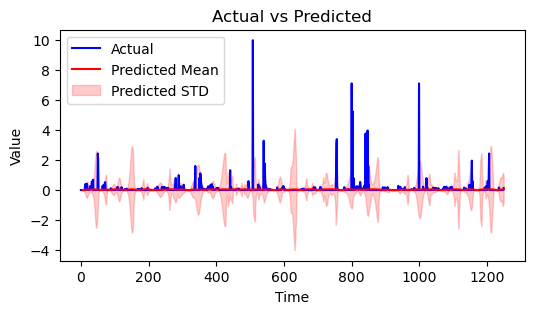

In [35]:
f, ax = plt.subplots(1, 1, figsize=(6, 3))

ax.plot(time_axis, actual_targets, label='Actual', color='blue')

ax.plot(time_axis[seq_length:], mu_preds, label='Predicted Mean', color='red')

ax.fill_between(time_axis[seq_length:], 
                mu_preds - np.sqrt(var_preds), 
                mu_preds + np.sqrt(var_preds), 
                color='red', alpha=0.2, label='Predicted STD')

ax.set_xlabel('Time')
ax.set_ylabel('Value')
ax.set_title('Actual vs Predicted')
ax.legend()

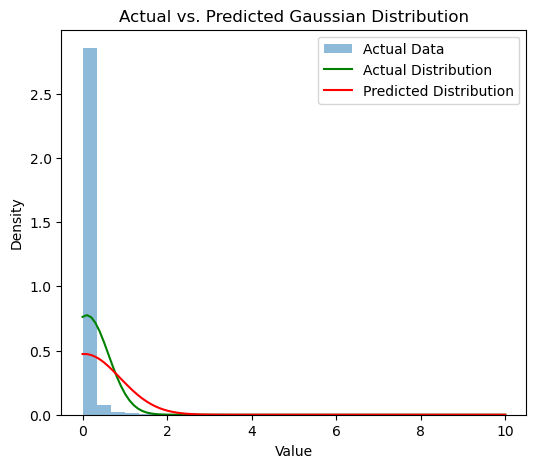

In [38]:
# Ensure predictions are numpy arrays for plotting
mu_preds = mu_preds.squeeze()
var_preds = var_preds.squeeze()

# Select a specific prediction (e.g., the last one)
selected_mu_pred = mu_preds[-1]
selected_var_pred = var_preds[-1]

# Generate a grid of values
x_vals = np.linspace(min(actual_targets), max(actual_targets), 100)

# Calculate the actual mean and variance of your target data
actual_mu = np.mean(actual_targets)
actual_var = np.var(actual_targets)

# Generate the Gaussian distributions
predicted_dist = (1 / (np.sqrt(2 * np.pi * selected_var_pred))) * np.exp(- (x_vals - selected_mu_pred)**2 / (2 * selected_var_pred))
actual_dist = (1 / (np.sqrt(2 * np.pi * actual_var))) * np.exp(- (x_vals - actual_mu)**2 / (2 * actual_var))

# Plotting using subplots style
f, ax = plt.subplots(1, 1, figsize=(6, 5))

# Histogram of actual targets
ax.hist(actual_targets, bins=30, density=True, alpha=0.5, label="Actual Data")

# Actual and predicted Gaussian distributions
ax.plot(x_vals, actual_dist, 'g', label="Actual Distribution")
ax.plot(x_vals, predicted_dist, 'r', label="Predicted Distribution")

ax.set_title("Actual vs. Predicted Gaussian Distribution")
ax.set_xlabel("Value")
ax.set_ylabel("Density")
ax.legend()
